# Préparation des données

## Import et data augmentations

In [1]:
from  src.dataloader import *
from src.bdappv import *
from src.metrics import *
from src.resnet18 import *
from src.confusion_matrix import make_confusion_matrix
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torch.nn as nn
import tensorflow as tf
from sklearn.metrics import fbeta_score, make_scorer, f1_score, accuracy_score, recall_score, precision_score, fbeta_score, precision_recall_curve, auc, roc_curve, log_loss, confusion_matrix
import torchvision.models as models
import os
from src.tsne import *
from torch.utils.data import DataLoader
import matplotlib
import torchvision.models as models
from sklearn.manifold import TSNE
import math

c:\Users\yanis\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] La procédure spécifiée est introuvable
  warn(f"Failed to load image Python extension: {e}")


In [2]:
dataset=BDAPPVClassification(img_dir="C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google3", size=None)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [3]:
mean, std = batch_mean_and_sd(dataloader)
print("Moyenne par channel: {}".format(mean.tolist()))
print("Ecart-type par channel: {}".format(std.tolist()))

Moyenne par channel: [0.346024751663208, 0.35355815291404724, 0.3038492202758789]
Ecart-type par channel: [0.20496879518032074, 0.18832367658615112, 0.18234187364578247]


In [4]:
dataset_crop=BDAPPVClassification(img_dir="C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google3",
                                  size=224,
                                  transform=transforms.Compose([transforms.Normalize(mean = mean,
                                                                    std= std)]))


716


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 224, 224])
tensor(0)


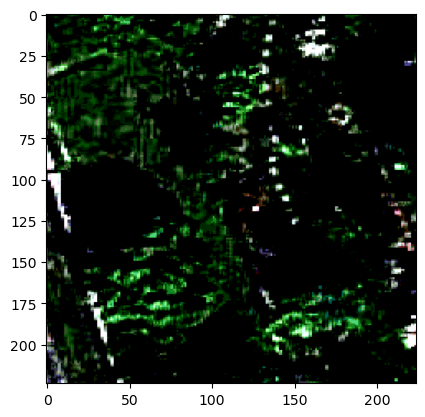

In [5]:
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

dataset_crop=BDAPPVClassification(img_dir="C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google3",
                                  size=224,
                                  transform=transforms.Compose([transforms.Normalize(mean = mean,
                                                                    std= std)]))

# Define the indices for training and testing sets
n = len(dataset)
train_size = int(0.8 * n)
test_size = n - train_size
train_indices = torch.arange(0, train_size)
test_indices = torch.arange(train_size, n)

# Define the samplers for training and testing sets
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Define the dataloaders for training and testing sets
train_dataloader_augmente = DataLoader(dataset_crop, batch_size=32, sampler=train_sampler)
test_dataloader_augmente = DataLoader(dataset_crop, batch_size=32, sampler=test_sampler)

print(len(train_dataloader_augmente))
batch = next(iter(train_dataloader_augmente))
print(batch[0].shape)
plt.imshow(batch[0][0].permute(1, 2, 0))
print(batch[1][0])

# Import du modèle

In [6]:
resnet18 = models.resnet18(pretrained=True)

#Furthermore, in feature extracting, we don't need to calculate gradient for any layers except 
# the last layer that we initialize. For this we need to set .requires_grad to False
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
set_parameter_requires_grad(resnet18)


nr_filters = resnet18.fc.in_features  #number of input features of last layer
#On ne met pas de sigmoid dans la dernière couche. C'est composé par la loss BCEWithLogitsLoss qui applique une sigmoid afin de calculer la cross-enthropy
resnet18.fc = nn.Linear(nr_filters, 1)


# Choix du Learning Rate

In [7]:
params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 fc.weight
	 fc.bias


In [8]:
def find_lr(train_loader=train_dataloader_augmente, optimizer=torch.optim.SGD(params_to_update, lr = 0.01, momentum=0.9, weight_decay=1e-4), init_value = 1e-8, final_value=10., beta = 0.98, criterion=nn.BCEWithLogitsLoss()):
    #Adapté de https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html
    num = len(train_loader)-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    for data, label in train_loader:
        batch_num += 1
        #As before, get theloss for this mini-batch of inputs/outputs
        optimizer.zero_grad()
        output = resnet18(data)
            
        loss = criterion(output,label.unsqueeze(1).float()) #loss sur le batch i.e 1/32*sum...
        #Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) *loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        #Store the values
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        #Do the SGD step
        loss.backward()
        optimizer.step()
        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, losses


In [9]:
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

log_lrs, losses=find_lr(train_loader=train_dataloader_augmente, optimizer=torch.optim.SGD(params_to_update, lr = 0.01, momentum=0.9, weight_decay=1e-4), init_value = 1e-8, final_value=10., beta = 0.98, criterion=nn.BCEWithLogitsLoss())

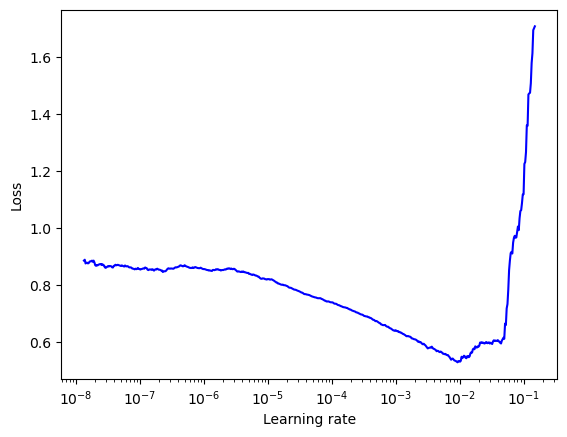

In [10]:
lrs=[10**k for k in log_lrs]
fig, ax = plt.subplots()

ax.plot(lrs[10:-5], losses[10:-5], 'b',label="Loss en fonction du learning rate", color="blue")
ax.set_xlabel("Learning rate")
ax.set_ylabel("Loss")
ax.set_xscale('log')
plt.show()

Le minimum de la loss est atteint pour un learning rate environ égal à 0,01. On remarque que la courbe de loss décroit le plus rapidement vers ce minimum pour un learning rate environ égal à 0,001. Cela semble être un bon choix.

# Fit et predict

In [11]:
def sig(x):
    return 1/(1 + np.exp(-x))

def train_model(model, train_loader, valid_loader, criterion, n_epochs, path_save_model, device=None):
    """Pour entrainer le modèle 
    /!\ certains commentaires sont à passer en code pour passer sur GPU
    """
    # number of epochs to train the model

    train_losses= []
    train_f1s=[]
    train_accuracys=[]
    train_recalls=[]
    train_precisions=[]
    train_f2s=[]

    valid_loss_min = np.Inf  # set initial "min" to infinity
    val_losses= []
    val_f1s=[]
    val_accuracys=[]
    val_recalls=[]
    val_precisions=[]
    val_f2s=[]

    # Here we only want to update the gradient for the classifier layer that we initialized.
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)

    optimizer=torch.optim.SGD(params_to_update, lr = 0.001, momentum=0.9, weight_decay=1e-4)
    
    for epoch in range(n_epochs):

        # monitor losses
        train_loss = 0
        train_f1=0
        train_accuracy=0
        train_recall=0
        train_precision=0
        train_f2=0

        valid_loss=0
        valid_f1=0
        valid_accuracy=0
        valid_recall=0
        valid_precision=0
        valid_f2=0

        iter_train=0
        iter_val=0
        ###################
        # train the model #
        ###################
        model.train() # prep model for training

        for data,label in train_loader:
            iter_train+=1

            # Pour utiliser GPU

            # inputs = inputs.to(device)
            # labels = labels.to(device)
            # model.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            output_detach = output.detach()

            # calculate the loss
            preds=torch.zeros(output_detach.shape[0], output_detach.shape[1])
            for i in range(len(output_detach)):
                if sig(output_detach[i])>0.5:
                    preds[i]=1
                else: preds[i]=0

            loss = criterion(output,label.unsqueeze(1).float()) #loss sur le batch i.e 1/32*sum...
            f1 = f1_score(label.numpy(), preds.T.numpy()[0])
            accuracy= accuracy_score(label.numpy(), preds.T.numpy()[0])
            recall= recall_score(label.numpy(), preds.T.numpy()[0])
            precision=precision_score(label.numpy(), preds.T.numpy()[0])
            f2=fbeta_score(label.numpy(), preds.T.numpy()[0], beta=2)

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss

            #loss.item(): retourne la valeur numérique de la loss transférée au CPU
            #loss.item() retourne la loss moyenne sur le mini-batch, d'où la multiplication
            #par data.size(0)
            train_loss += loss.item() * data.size(0)
            train_f1+=f1
            train_accuracy+=accuracy
            train_recall+=recall
            train_precision+=precision
            train_f2+=f2

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = train_loss / len(train_loader.sampler) 
        train_f1=train_f1/iter_train
        train_accuracy=train_accuracy/iter_train
        train_recall=train_recall/iter_train
        train_precision=train_precision/iter_train
        train_f2=train_f2/iter_train


        train_losses.append(train_loss)
        train_f1s.append(train_f1)
        train_accuracys.append(train_accuracy)
        train_recalls.append(train_recall)
        train_precisions.append(train_precision)
        train_f2s.append(train_f2)

        model.eval()

        for data,label in valid_loader:
            iter_val+=1

            # Pour utiliser GPU

            # inputs = inputs.to(device)
            # labels = labels.to(device)
            # model.to(device)

            with torch.no_grad():
                output = model(data)
                
            output_detach = output.detach()

            # calculate the loss
            preds=torch.zeros(output_detach.shape[0], output_detach.shape[1])
            for i in range(len(output_detach)):
                if sig(output_detach[i])>0.5:
                    preds[i]=1
                else: preds[i]=0
            
            loss = criterion(output,label.unsqueeze(1).float())
            f1 = f1_score(label.numpy(), preds.T.numpy()[0])
            accuracy= accuracy_score(label.numpy(), preds.T.numpy()[0])
            recall= recall_score(label.numpy(), preds.T.numpy()[0])
            precision= precision_score(label.numpy(), preds.T.numpy()[0])
            f2=fbeta_score(label.numpy(), preds.T.numpy()[0], beta=2)

            # update running validation loss 
            valid_loss+=loss.item() * data.size(0)
            valid_f1+=f1
            valid_accuracy+=accuracy
            valid_recall+=recall
            valid_precision+=precision
            valid_f2+=f2

        valid_loss=valid_loss/len(valid_loader.sampler)
        valid_f1=valid_f1/iter_val
        valid_accuracy=valid_accuracy/iter_val
        valid_recall=valid_recall/iter_val
        valid_precision=valid_precision/iter_val
        valid_f2=valid_f2/iter_val

        val_losses.append(valid_loss)
        val_f1s.append(valid_f1)
        val_accuracys.append(valid_accuracy)
        val_recalls.append(valid_recall)
        val_precisions.append(valid_precision)
        val_f2s.append(valid_f2)



        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining F1-score: {:.6f} \tTraining accuracy: {:.6f} \tTraining recall: {:.6f} \tTraining precision: {:.6f} \tTraining F2-score: {:.6f} \tValidation Loss: {:.6f} \tValidation F1-score: {:.6f} \tValidation accuracy: {:.6f} \tValidation recall: {:.6f} \tValidation precision: {:.6f} \tValidation F2-score: {:.6f}'.format(
            epoch+1, 
            train_loss,
            train_f1,
            train_accuracy,
            train_recall,
            train_precision,
            train_f2,
            valid_loss,
            valid_f1,
            valid_accuracy,
            valid_recall,
            valid_precision,
            valid_f2
            ))
        
    torch.save(model.state_dict(), os.path.join(path_save_model,"trained_resnet18_autocrop.pth"))

    return train_losses, train_f1s, train_accuracys, train_recalls, train_precisions, train_f2s, val_losses, val_f1s, val_accuracys, val_recalls, val_precisions, val_f2s


def eval_model(model, path_model, valid_loader, criterion, n_epochs, device=None):
    """Pour voir les performances du modèle entraîné sur l'échantillon de validation
       /!\ certains commentaires sont à passer en code pour passer sur GPU

    """
    ######################    
    # validate the model #
    ######################
    valid_loss_min = np.Inf  # set initial "min" to infinity
    val_losses= []
    val_f1s=[]
    val_accuracys=[]
    val_recalls=[]
    val_precisions=[]
    val_f2s=[]

    model.load_state_dict(torch.load(path_model))
    model.eval()  # prep model for evaluation

    #model.to(device)

    for epoch in range(n_epochs):
        valid_loss=0
        valid_f1=0
        valid_accuracy=0
        valid_recall=0
        valid_precision=0
        valid_f2=0
        iter=0
        for data,label in valid_loader:

            # Pour utiliser GPU

            # inputs = inputs.to(device)
            # labels = labels.to(device)
            # model.to(device)

            with torch.no_grad():
                output = model(data)
                
            output_detach = output.detach()

            # calculate the loss
            preds=torch.zeros(output_detach.shape[0], output_detach.shape[1])
            for i in range(len(output_detach)):
                if sig(output_detach[i])>0.5:
                    preds[i]=1
                else: preds[i]=0
            
            loss = criterion(output,label.unsqueeze(1).float())
            f1 = f1_score(label.numpy(), preds.T.numpy()[0])
            accuracy= accuracy_score(label.numpy(), preds.T.numpy()[0])
            recall= recall_score(label.numpy(), preds.T.numpy()[0])
            precision= precision_score(label.numpy(), preds.T.numpy()[0])
            f2=fbeta_score(label.numpy(), preds.T.numpy()[0], beta=2)

            # update running validation loss 
            valid_loss+=loss.item() * data.size(0)
            valid_f1+=f1
            valid_accuracy+=accuracy
            valid_recall+=recall
            valid_precision+=precision
            valid_f2+=f2
            iter+=1

        valid_loss=valid_loss/len(valid_loader.sampler)
        valid_f1=valid_f1/iter
        valid_accuracy=valid_accuracy/iter
        valid_recall=valid_recall/iter
        valid_precision=valid_precision/iter
        valid_f2=valid_f2/iter

        val_losses.append(valid_loss)
        val_f1s.append(valid_f1)
        val_accuracys.append(valid_accuracy)
        val_recalls.append(valid_recall)
        val_precisions.append(valid_precision)
        val_f2s.append(valid_f2)

        print('Epoch: {} \tValidation Loss: {:.6f} \tValidation F1-score: {:.6f} \tValidation accuracy: {:.6f} \tValidation recall: {:.6f} \tValidation precision: {:.6f} \tValidation F2-score: {:.6f}'.format(
            epoch+1,
            valid_loss,
            valid_f1,
            valid_accuracy,
            valid_recall,
            valid_precision,
            valid_f2
            ))
        
    return val_losses, val_f1s, val_accuracys, val_recalls, val_precisions, val_f2s


def predict(model, path_model, valid_loader, device=None):
    """Pour prédire 0/1 à partir de l'échantillon de validation
       /!\ certains commentaires sont à passer en code pour passer sur GPU

    """
    model.load_state_dict(torch.load(path_model))
    model.eval()

    array_labels=np.array([])
    array_preds=np.array([])
    probas_pred=np.array([])

    for data,label in valid_loader:
        # Pour utiliser GPU

        # inputs = inputs.to(device)
        # labels = labels.to(device)
        # model.to(device)

        with torch.no_grad():
            output = model(data)
        output_detach = output.detach()

        # calculate the loss
        preds=torch.zeros(output_detach.shape[0], output_detach.shape[1])
        probas=torch.zeros(output_detach.shape[0], output_detach.shape[1])

        for i in range(len(output_detach)):
            if sig(output_detach[i])>0.5:
                preds[i]=1
            else: preds[i]=0
            probas[i]=sig(output_detach[i])
        probas_pred=np.append(probas_pred, probas.T.numpy()[0])
        array_preds=np.append(array_preds,preds.T.numpy()[0])
        array_labels=np.append(array_labels, label.numpy())

    return array_labels, array_preds, probas_pred

In [12]:
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss=nn.BCEWithLogitsLoss()
# Train model
train_losses, train_f1s, train_accuracys, train_recalls, train_precisions, train_f2s, val_losses, val_f1s, val_accuracys, val_recalls, val_precisions, val_f2s = train_model(model=resnet18, 
                                                                                 train_loader=train_dataloader_augmente,
                                                                                 valid_loader=test_dataloader_augmente, 
                                                                                 criterion=loss, 
                                                                                 n_epochs=40, 
                                                                                 path_save_model="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps",
                                                                                 device=None)

	 fc.weight
	 fc.bias
Epoch: 1 	Training Loss: 1.918183 	Training F1-score: 0.795797 	Training accuracy: 0.786014 	Training recall: 0.802887 	Training precision: 0.800824 	Training F2-score: 0.798497 	Validation Loss: 1.533892 	Validation F1-score: 0.806889 	Validation accuracy: 0.800420 	Validation recall: 0.824018 	Validation precision: 0.800666 	Validation F2-score: 0.815745
Epoch: 2 	Training Loss: 1.436101 	Training F1-score: 0.796649 	Training accuracy: 0.787026 	Training recall: 0.801302 	Training precision: 0.804214 	Training F2-score: 0.797945 	Validation Loss: 1.285759 	Validation F1-score: 0.800477 	Validation accuracy: 0.790649 	Validation recall: 0.827764 	Validation precision: 0.783989 	Validation F2-score: 0.815330
Epoch: 3 	Training Loss: 1.102132 	Training F1-score: 0.795940 	Training accuracy: 0.786125 	Training recall: 0.802044 	Training precision: 0.802400 	Training F2-score: 0.798001 	Validation Loss: 0.951937 	Validation F1-score: 0.797289 	Validation accuracy: 0.

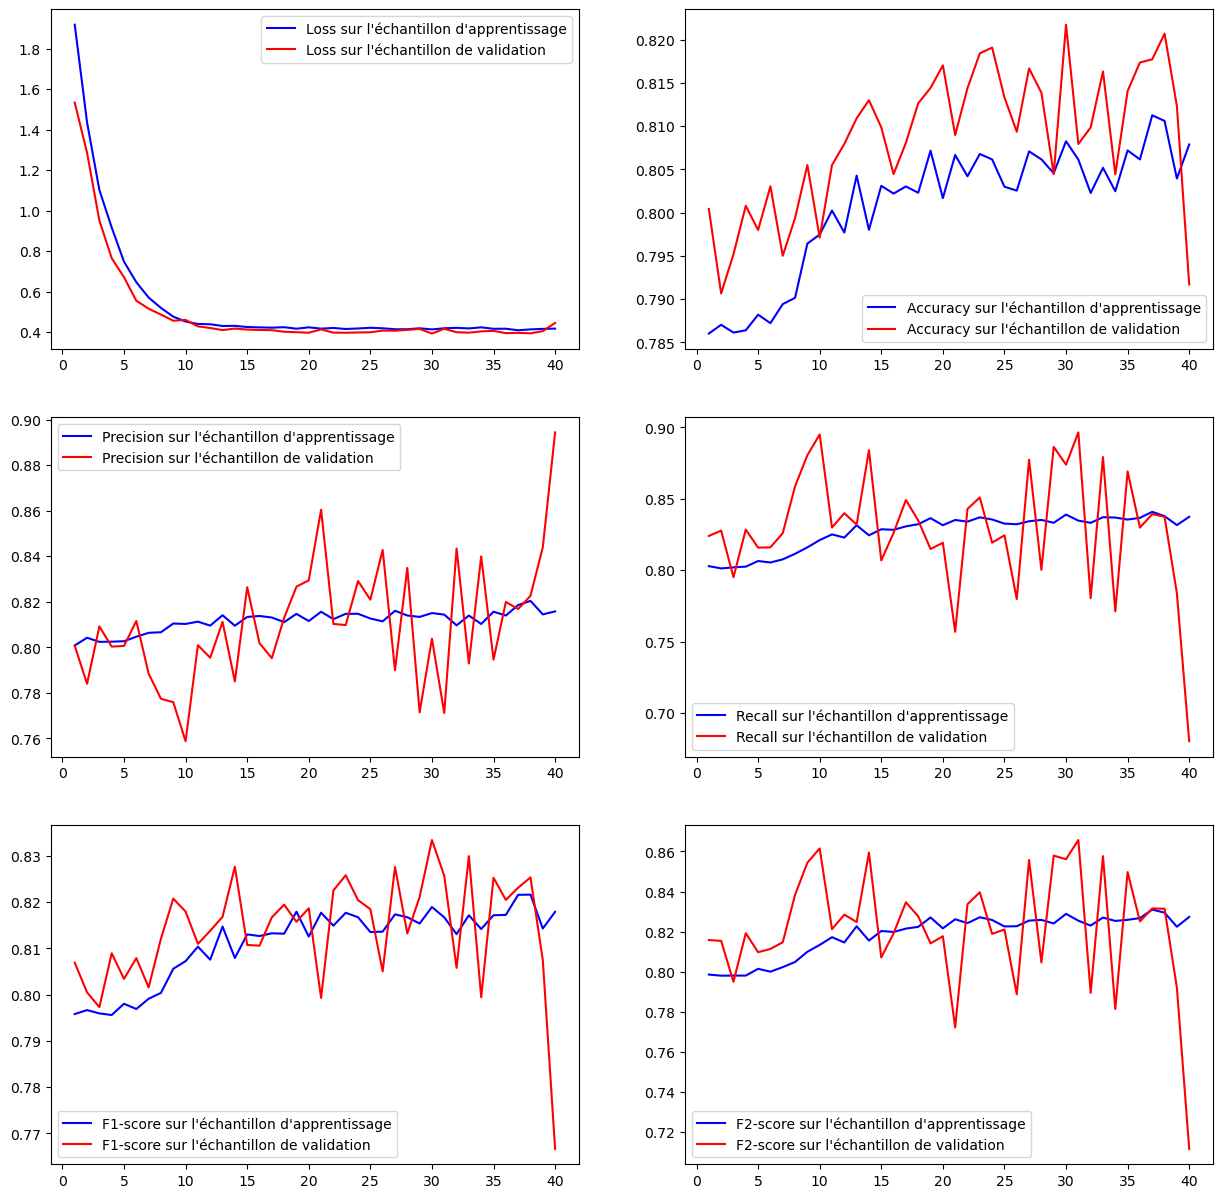

In [13]:
dict_train_losses={}
dict_train_f1s={}
dict_train_accuracys={}
dict_train_recalls={}
dict_train_precisions={}
dict_train_f2s={}

dict_val_losses={}
dict_val_f1s={}
dict_val_accuracys={}
dict_val_recalls={}
dict_val_precisions={}
dict_val_f2s={}

for i in range(0,40):
    dict_train_losses[i+1]=train_losses[i]
    dict_train_f1s[i+1]=train_f1s[i]
    dict_train_accuracys[i+1]=train_accuracys[i]
    dict_train_recalls[i+1]=train_recalls[i]
    dict_train_precisions[i+1]=train_precisions[i]
    dict_train_f2s[i+1]=train_f2s[i]

    dict_val_losses[i+1]=val_losses[i]
    dict_val_f1s[i+1]=val_f1s[i]
    dict_val_accuracys[i+1]=val_accuracys[i]
    dict_val_recalls[i+1]=val_recalls[i]
    dict_val_precisions[i+1]=val_precisions[i]
    dict_val_f2s[i+1]=val_f2s[i]

sorted_train_losses = sorted(dict_train_losses.items())
sorted_train_f1s = sorted(dict_train_f1s.items())
sorted_train_accuracys = sorted(dict_train_accuracys.items())
sorted_train_recalls = sorted(dict_train_recalls.items())
sorted_train_precisions = sorted(dict_train_precisions.items())
sorted_train_f2s = sorted(dict_train_f2s.items())

sorted_val_losses = sorted(dict_val_losses.items())
sorted_val_f1s = sorted(dict_val_f1s.items())
sorted_val_accuracys = sorted(dict_val_accuracys.items())
sorted_val_recalls = sorted(dict_val_recalls.items())
sorted_val_precisions = sorted(dict_val_precisions.items())
sorted_val_f2s = sorted(dict_val_f2s.items())

epochs, loss_train = zip(*sorted_train_losses)
epochs, f1_train = zip(*sorted_train_f1s)
epochs, acc_train = zip(*sorted_train_accuracys)
epochs, recall_train = zip(*sorted_train_recalls)
epochs, precision_train =zip(*sorted_train_precisions)
epochs, f2_train = zip(*sorted_train_f2s)

epochs, loss_val = zip(*sorted_val_losses)
epochs, f1_val = zip(*sorted_val_f1s)
epochs, acc_val = zip(*sorted_val_accuracys)
epochs, recall_val = zip(*sorted_val_recalls)
epochs, precision_val =zip(*sorted_val_precisions)
epochs, f2_val = zip(*sorted_val_f2s)


fig, axs = plt.subplots(3, 2, figsize=(15, 15))

axs[0,0].plot(epochs, loss_train, 'b',label="Loss sur l'échantillon d'apprentissage", color="blue")
axs[0,0].plot(epochs, loss_val, 'b',label="Loss sur l'échantillon de validation", color="red")
axs[0,0].legend()

axs[0,1].plot(epochs, acc_train, 'b',label="Accuracy sur l'échantillon d'apprentissage", color="blue")
axs[0,1].plot(epochs, acc_val, 'b',label="Accuracy sur l'échantillon de validation", color="red")
axs[0,1].legend()

axs[1,0].plot(epochs, precision_train, 'b',label="Precision sur l'échantillon d'apprentissage", color="blue")
axs[1,0].plot(epochs, precision_val, 'b',label="Precision sur l'échantillon de validation", color="red")
axs[1,0].legend()

axs[1,1].plot(epochs, recall_train, 'b',label="Recall sur l'échantillon d'apprentissage", color="blue")
axs[1,1].plot(epochs, recall_val, 'b',label="Recall sur l'échantillon de validation", color="red")
axs[1,1].legend()

axs[2,0].plot(epochs, f1_train, 'b',label="F1-score sur l'échantillon d'apprentissage", color="blue")
axs[2,0].plot(epochs, f1_val, 'b',label="F1-score sur l'échantillon de validation", color="red")
axs[2,0].legend()

axs[2,1].plot(epochs, f2_train, 'b',label="F2-score sur l'échantillon d'apprentissage", color="blue")
axs[2,1].plot(epochs, f2_val, 'b',label="F2-score sur l'échantillon de validation", color="red")
axs[2,1].legend()

plt.savefig('courbes_loss_resnet18_transfertlearning.png')
plt.show()


In [14]:
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

y_true_train, y_pred_train, proba_pred_train=predict(model=resnet18, path_model="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/trained_resnet18_autocrop.pth", valid_loader=train_dataloader_augmente, device=None)
y_true_val, y_pred_val, proba_pred_val=predict(model=resnet18, path_model="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/trained_resnet18_autocrop.pth", valid_loader=test_dataloader_augmente, device=None)

Loss sur l'échantillon train: 0.44
Accuracy sur l'échantillon train: 0.79
Recall sur l'échantillon train: 0.69
Precision sur l'échantillon train: 0.89
F1-score sur l'échantillon train: 0.78
F2-score sur l'échantillon train: 0.72 

Loss sur l'échantillon test: 0.44
Accuracy sur l'échantillon test: 0.79
Recall sur l'échantillon test: 0.68
Precision sur l'échantillon test: 0.9
F1-score sur l'échantillon test: 0.77
F2-score sur l'échantillon test: 0.71
AUC: 0.9


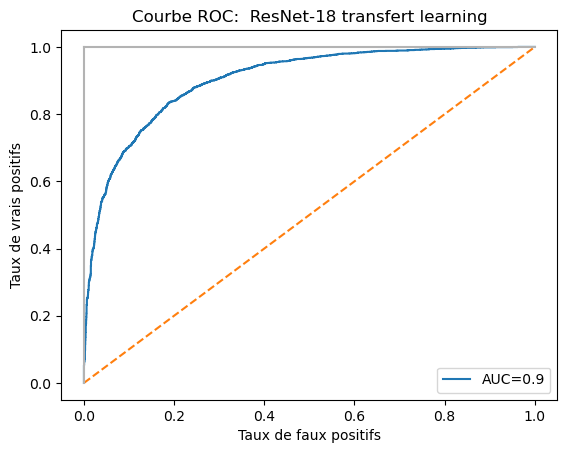

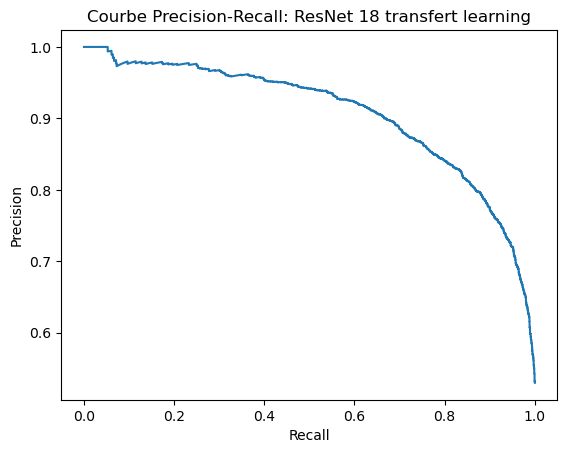

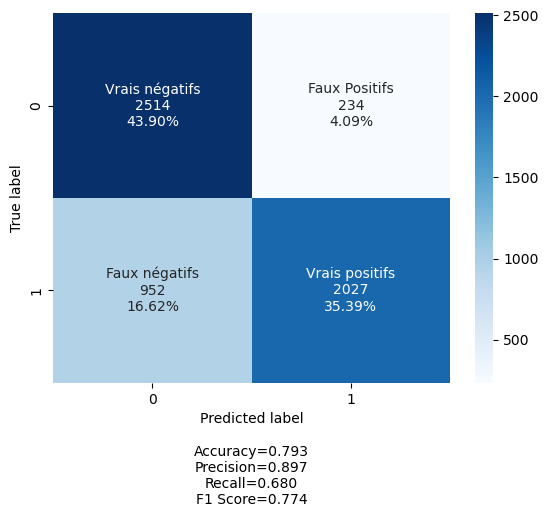

In [15]:
print("Loss sur l'échantillon train: {}".format(round(log_loss(y_true_train, proba_pred_train),2)))
print("Accuracy sur l'échantillon train: {}".format(round(accuracy_score(y_true_train, y_pred_train),2)))
print("Recall sur l'échantillon train: {}".format(round(recall_score(y_true_train, y_pred_train),2)))
print("Precision sur l'échantillon train: {}".format(round(precision_score(y_true_train, y_pred_train),2)))
print("F1-score sur l'échantillon train: {}".format(round(f1_score(y_true_train, y_pred_train),2)))
print("F2-score sur l'échantillon train: {} \n".format(round(fbeta_score(y_true_train, y_pred_train, beta=2),2)))

print("Loss sur l'échantillon test: {}".format(round(log_loss(y_true_val, proba_pred_val),2)))
print("Accuracy sur l'échantillon test: {}".format(round(accuracy_score(y_true_val, y_pred_val),2)))
print("Recall sur l'échantillon test: {}".format(round(recall_score(y_true_val, y_pred_val),2)))
print("Precision sur l'échantillon test: {}".format(round(precision_score(y_true_val, y_pred_val),2)))
print("F1-score sur l'échantillon test: {}".format(round(f1_score(y_true_val, y_pred_val),2)))
print("F2-score sur l'échantillon test: {}".format(round(fbeta_score(y_true_val, y_pred_val, beta=2),2)))

FP_rate, TP_rate, thresholds_keras = roc_curve(y_true_val, proba_pred_val)
AUC= auc(FP_rate, TP_rate)
print("AUC: {}".format(round(AUC, 2)))

plt.title('Courbe ROC:  ResNet-18 transfert learning')
plt.plot(FP_rate, TP_rate, label="AUC="+str(round(AUC, 2)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.legend(loc=4)
plt.savefig('ROC_resnet18_transfertlearning_crop.png')
plt.show()

prec, rec, thresholds_keras = precision_recall_curve(y_true_val, proba_pred_val)

fig, ax = plt.subplots()
ax.plot(rec, prec)

#add axis labels to plot
ax.set_title('Courbe Precision-Recall: ResNet 18 transfert learning')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.savefig('prec_recall_resnet18_transfertlearning_crop.png')
plt.show()

r = confusion_matrix(y_true_val, y_pred_val)

labels = ["Vrais négatifs", "Faux Positifs", "Faux négatifs", "Vrais positifs"]
categories = ["0", "1"]
make_confusion_matrix(r,
                      group_names=labels,
                      categories=categories,
                      )

# Visualisation TSNE

In [16]:
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

dataset_tsne=BDAPPVClassification_path(img_dir="C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google3",
                                  size=224,
                                  transform=transforms.Compose([transforms.Normalize(mean = mean,
                                                                    std= std)]))


# Define the samplers for training and testing sets
test_sampler_tsne = SubsetRandomSampler(test_indices)

# Define the dataloaders for training and testing sets
test_dataloader_tsne = DataLoader(dataset_tsne, batch_size=32, sampler=test_sampler_tsne)

In [17]:
def embedding(data):
    resnet18.eval()
    out = resnet18.conv1(data) #pass through CNN
    out= resnet18.bn1(out)
    out=resnet18.relu(out)
    out=resnet18.maxpool(out)
    out=resnet18.layer1(out)
    out=resnet18.layer2(out)
    out=resnet18.layer3(out)
    out=resnet18.layer4(out)
    out=torch.flatten(out, 1)
    return out

In [18]:
features = None
labels = None
image_paths = None

for data in test_dataloader_tsne:
    inputs=data[0]
    targets=data[1]
    paths=data[2]
    
    output = embedding(inputs)
    current_features = output.detach().numpy()
    if features is not None:
        features = np.concatenate((features, current_features))
    else:
        features = current_features

    if labels is not None:
        labels = np.concatenate((labels, targets))
    else:
        labels = targets
    
    if image_paths is not None:
        image_paths = np.concatenate((image_paths, paths))
    else:
        image_paths = paths

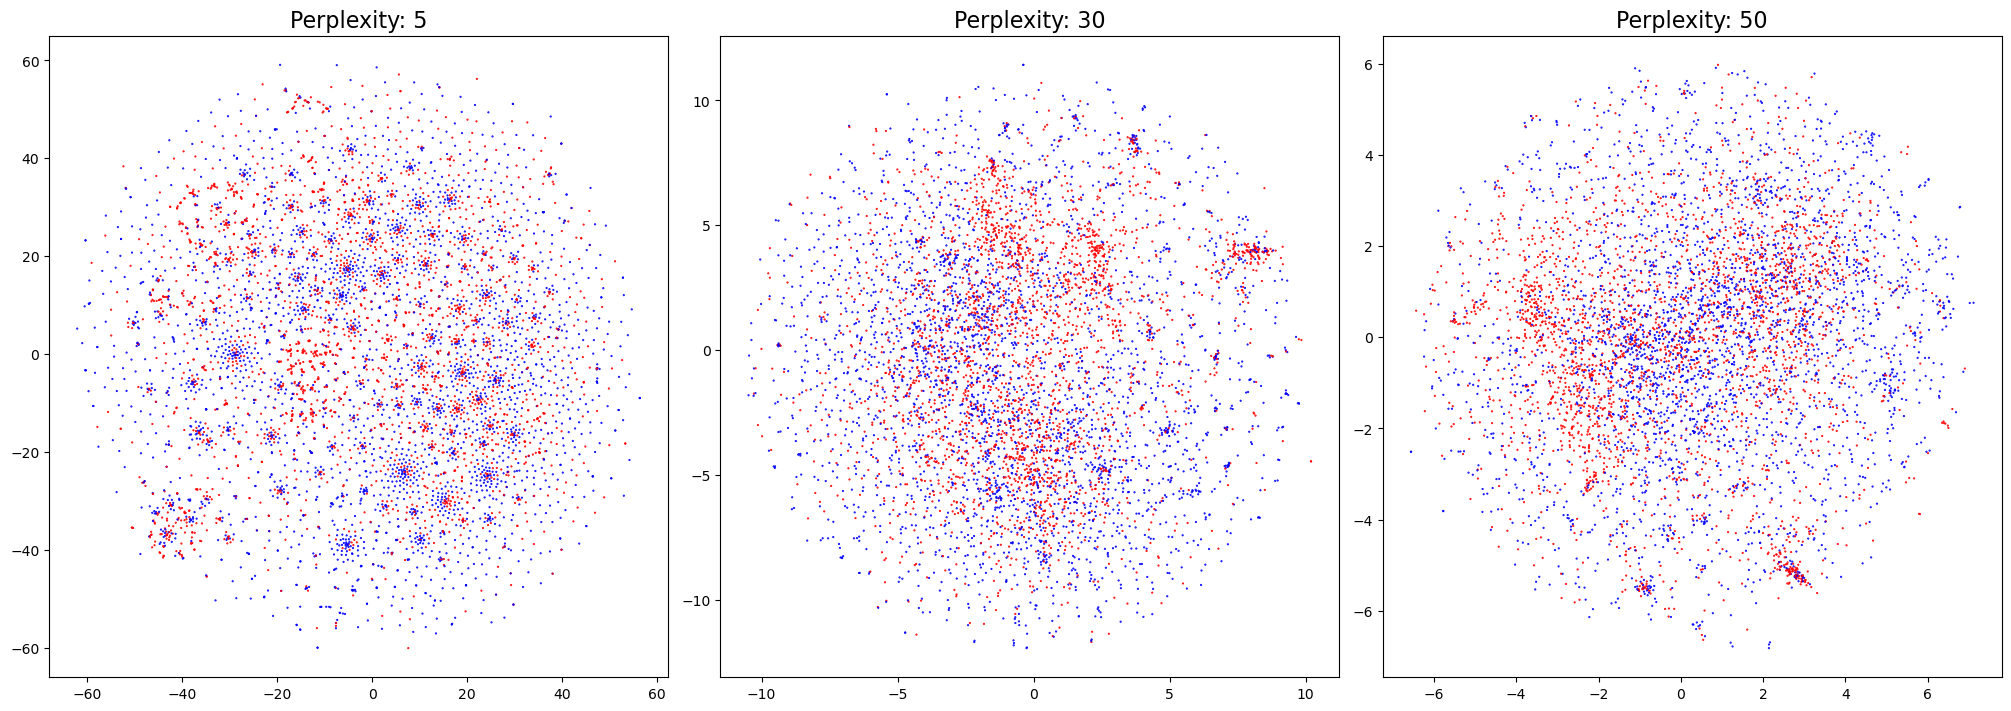

In [19]:
import itertools
fig, ax = plt.subplots(1, 3, figsize=(20,7), constrained_layout=True)

for c, per in zip(itertools.count(), [5, 30, 50]):
    tsne = TSNE(n_components=2,
                perplexity=per)
    tsne = tsne.fit_transform(features)
    scatter = ax[c].scatter(tsne[:, 0], tsne[:, 1], c=labels, cmap=matplotlib.colors.ListedColormap(["red", "blue"]), s=0.3)
    ax[c].set_title(f'Perplexity: {per}', fontsize=16) 

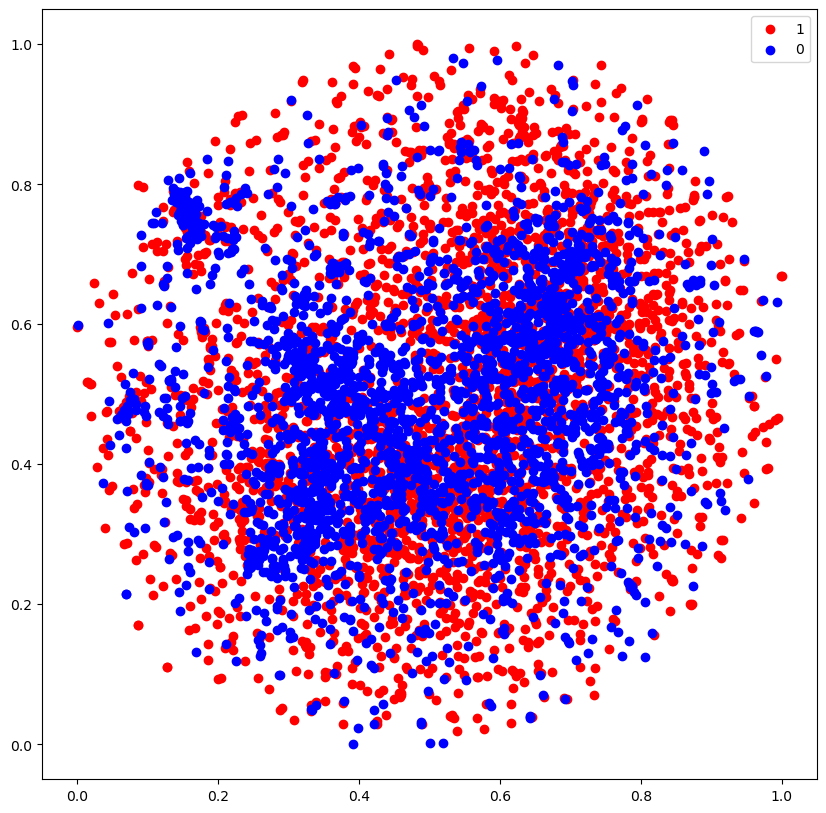

Building the T-SNE plot: 100%|██████████| 5727/5727 [00:23<00:00, 241.00it/s]


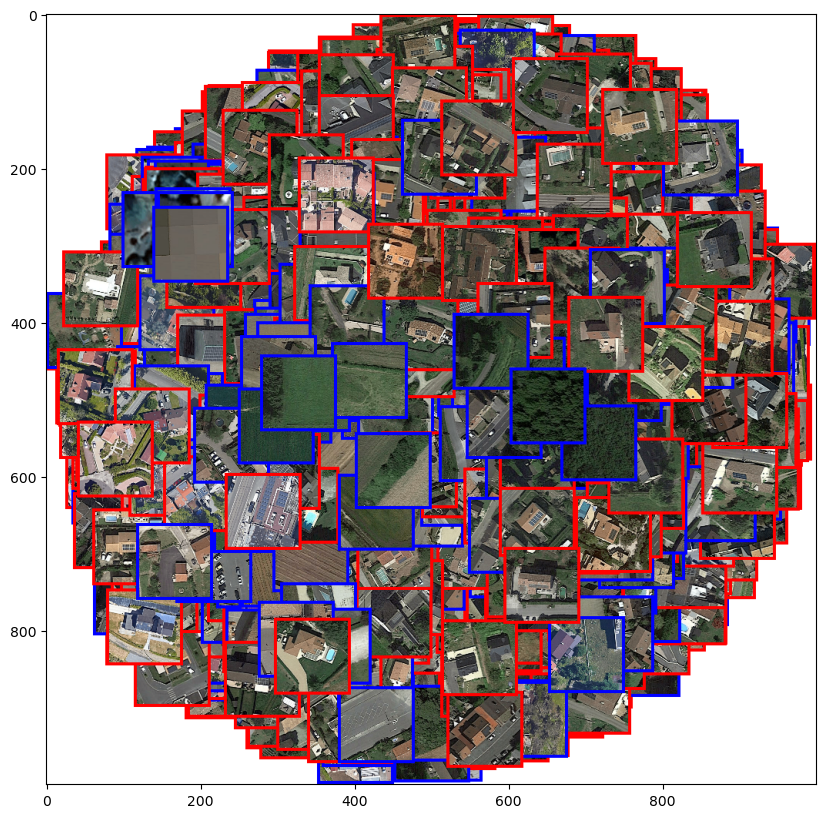

In [20]:
tsne = TSNE(n_components=2, perplexity=30).fit_transform(features)
visualize_tsne(tsne, image_paths, labels)